In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_test = pd.read_csv("Test_Data.csv")
df_test.drop(columns="SEQN", inplace=True)
df_test.head(3)

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,1.0,1.0,32.2,96.0,2.0,135.0,15.11
1,2.0,2.0,26.3,100.0,2.0,141.0,15.26
2,1.0,2.0,28.6,107.0,2.0,136.0,8.82


In [3]:
df_train = pd.read_csv("Train_Data.csv")
df_train.drop(columns="SEQN", inplace=True)
df_train.head(3)

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult


In [4]:
df_train.shape, df_test.shape

((1966, 8), (312, 7))

In [5]:
for col in df_train.columns:
    print(df_train[col].value_counts())

RIAGENDR
2.0    994
1.0    954
Name: count, dtype: int64
PAQ605
2.0    1606
1.0     346
7.0       1
Name: count, dtype: int64
BMXBMI
23.9    24
23.7    20
27.4    19
27.8    17
21.3    17
        ..
41.2     1
46.3     1
41.5     1
35.2     1
44.0     1
Name: count, Length: 332, dtype: int64
LBXGLU
96.0     107
94.0     102
99.0      92
100.0     85
95.0      83
        ... 
69.0       1
67.0       1
160.0      1
132.0      1
158.0      1
Name: count, Length: 95, dtype: int64
DIQ010
2.0    1879
3.0      50
1.0      19
Name: count, dtype: int64
LBXGLT
91.0     40
100.0    36
90.0     34
94.0     33
108.0    32
         ..
243.0     1
229.0     1
287.0     1
231.0     1
208.0     1
Name: count, Length: 224, dtype: int64
LBXIN
6.61     7
5.04     6
11.06    5
7.92     5
6.45     5
        ..
13.78    1
8.15     1
14.05    1
30.00    1
9.51     1
Name: count, Length: 1292, dtype: int64
age_group
Adult     1638
Senior     314
Name: count, dtype: int64


In [6]:
cat_cols = ["RIAGENDR", "PAQ605", "DIQ010", "age_group"]

In [7]:
for col in cat_cols:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    
    if col != "age_group":
        df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

In [8]:
for col in df_train.columns:
    if col not in cat_cols:
        df_train[col] = df_train[col].fillna(df_train[col].mean())
        df_test[col] = df_test[col].fillna(df_test[col].mean())
    else:
        continue

In [9]:
df_train.drop_duplicates(inplace=True)
df_train.shape

(1966, 8)

In [10]:
float_temp_cols = ["BMXBMI", "LBXGLU", "LBXGLT", "LBXIN", "age_group"]

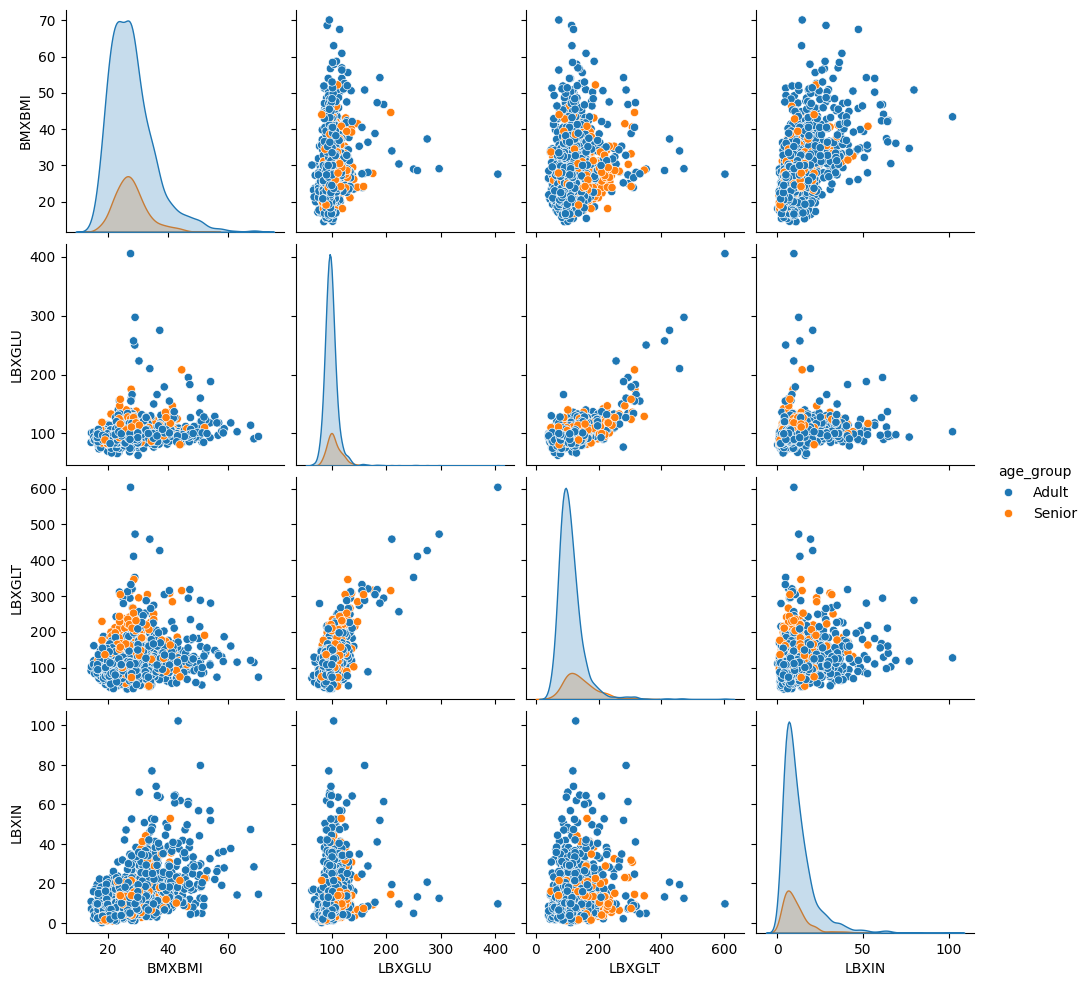

In [11]:
sns.pairplot(data=df_train[float_temp_cols], hue="age_group")
plt.show()

In [12]:
float_cols = ["BMXBMI", "LBXGLU", "LBXGLT", "LBXIN"]

In [13]:
df_train[float_cols] = np.log1p(df_train[float_cols])
df_test[float_cols] = np.log1p(df_test[float_cols])


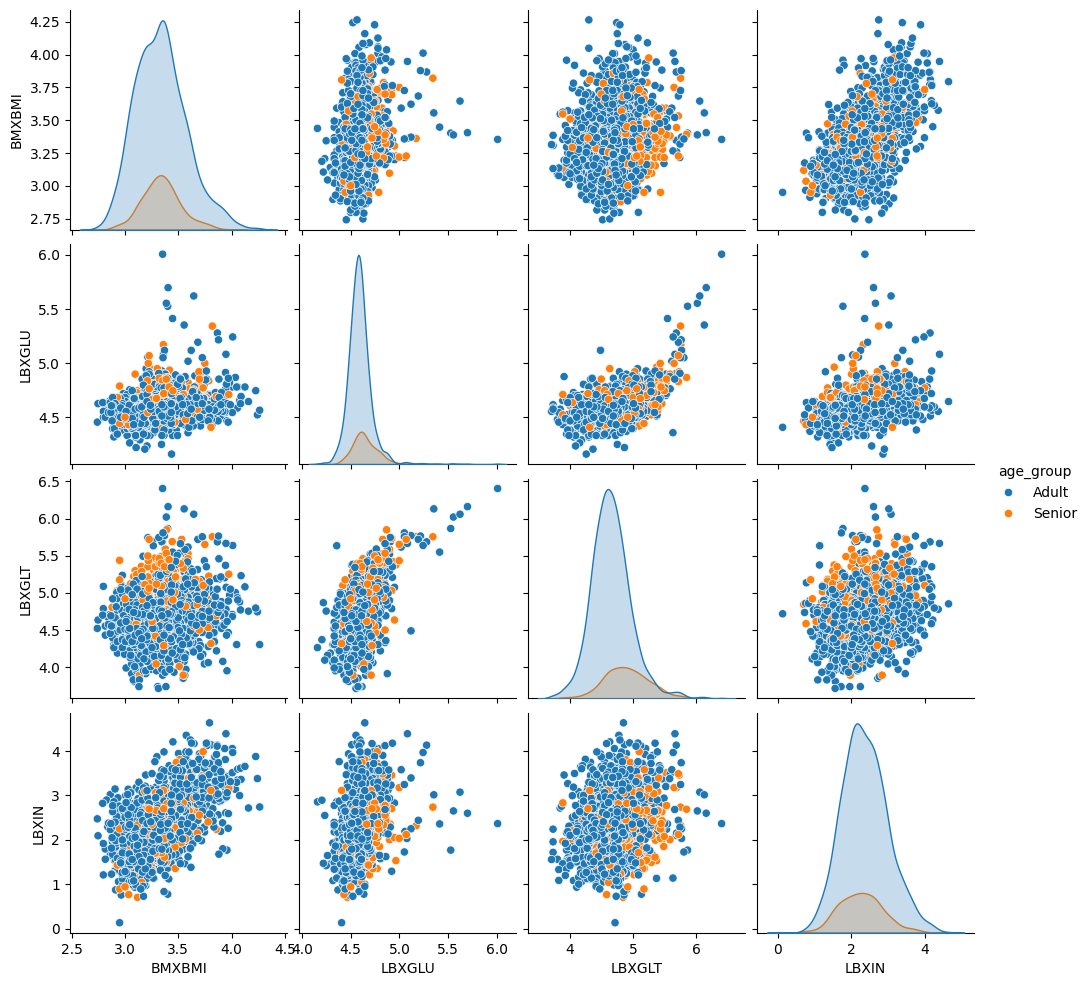

In [14]:
sns.pairplot(data=df_train[float_temp_cols], hue="age_group")
plt.show()

In [15]:
def replace_outliers_with_min_max(df, arr):
    df_out = df.copy()
    for col in arr:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        non_outliers = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)][col]
        min_val = non_outliers.min()
        max_val = non_outliers.max()

        df_out.loc[df_out[col] < lower_bound, col] = min_val
        df_out.loc[df_out[col] > upper_bound, col] = max_val
    return df_out

In [16]:
df_train = replace_outliers_with_min_max(df_train, float_cols)
df_test = replace_outliers_with_min_max(df_test, float_cols)

In [17]:
from sklearn.preprocessing import MinMaxScaler
for col in float_cols:
    ms = MinMaxScaler()
    df_train[col] = ms.fit_transform(df_train[[col]])
    df_test[col] = ms.fit_transform(df_test[[col]])

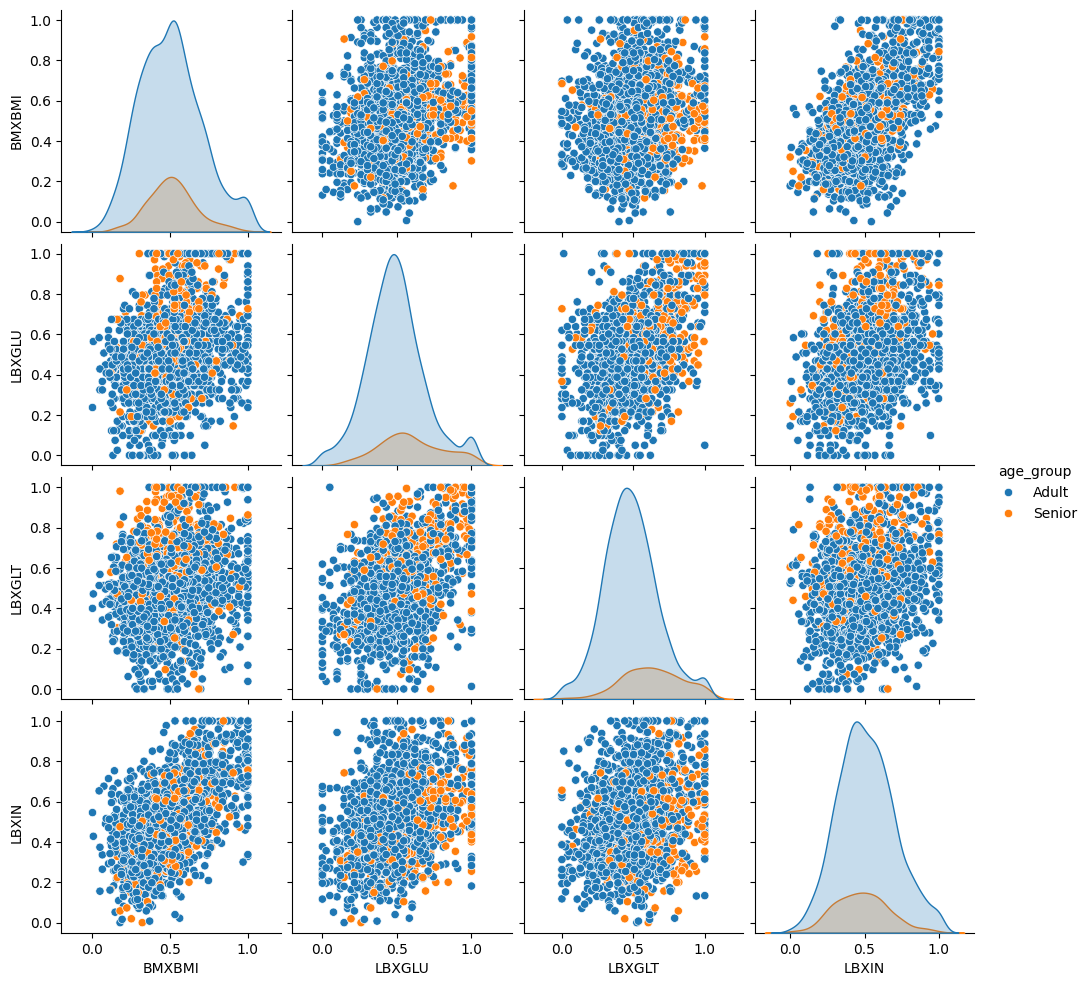

In [18]:
sns.pairplot(data=df_train[float_temp_cols], hue="age_group")
plt.show()

In [19]:
df_train["age_group"] = df_train["age_group"].map({"Adult":0, "Senior":1})

In [20]:
X = df_train.drop(columns="age_group", axis=1)
y = df_train["age_group"]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, stratify=y, random_state=19)

In [22]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=180, max_depth=10, min_samples_leaf=3, n_jobs=-1, random_state=19)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=180,
                       n_jobs=-1, random_state=19)

In [24]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)

(0.9312888198757764, 0.7829099307159353)

In [26]:
# from xgboost import XGBClassifier

# xgb = XGBClassifier( n_estimators=200,          # Number of trees
#     learning_rate=0.005,        # Step size shrinkage (eta)
#     max_depth=5,               # Max depth of each tree
#     subsample=0.75,             # % of training data used per tree
#     colsample_bytree=0.6,      # % of features used per tree
#     gamma=1.5,                   # Minimum loss reduction for further splits
#     reg_alpha=0.1,             # L1 regularization
#     reg_lambda=1.0,            # L2 regularization
#     min_child_weight=4,        # Minimum sum of instance weight (Hessian) needed in a child
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=19
# )
# xgb.fit(X_train, y_train)

In [27]:
# y_pred = xgb.predict(X_test)
# y_pred_train = xgb.predict(X_train)

In [28]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       364
           1       0.37      0.52      0.43        69

    accuracy                           0.78       433
   macro avg       0.64      0.68      0.65       433
weighted avg       0.82      0.78      0.80       433



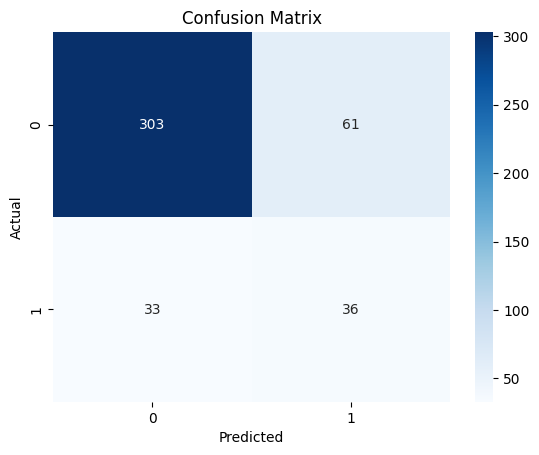

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
sub_pred = rf.predict(df_test)
sub_pred

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [33]:
submission = pd.DataFrame()
submission["age_group"] = sub_pred
submission

,age_group
0,0
1,0
2,1
3,0
4,0
...,...
307,0
308,0
309,0
310,0


In [34]:
submission.to_csv("model_submission.csv", index=False)